# Research work: Estimating PageRank with inductive capability of Graph Neural Networks and zone partitioning

## Experiment 2: CiteSeer Dataset

Three neural networks were created for computing
zone partitions metrics

In [1]:
from models import GCN, GraphSage, ChebConv, ChebyshevNet
import numpy as np
import matplotlib.pyplot as plt
from graph_utils import PartitionFactory
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.datasets import FacebookPagePage, GitHub, CitationFull
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import classification_report 
from graph_utils import plot_losses

In [2]:
''' Dataset selection '''
dataset = CitationFull(root='data/CiteSeer', name = "CiteSeer", transform=NormalizeFeatures())
data = dataset[0]

In [3]:
data.y.unique()

tensor([0, 1, 2, 3, 4, 5])

## Graph Partitioning stage: 
This stage separates graph onto 5 different zones

In [4]:
from graph_utils import coo_to_edge_list
from graph_utils import edge_list_to_adj_list
from collections import deque 
def graph_preprocess(data):
    graph = coo_to_edge_list(data)
    graph = edge_list_to_adj_list(graph)
    return graph

def flooding(graph, seed, step=10):
    '''Utilite function, returns the second seed for the second
    graph by traversing from the first graph's seed N number of steps
    uses BFS strategy
    '''
    queue = deque([seed])  # for BFS
    layer = {seed: 0}  # tracks visited nodes and depth
    while queue:
        node = queue.popleft()
        for neighbour in graph[node]:
            if neighbour not in layer:
                queue.append(neighbour)  # for the next iteration
                layer[neighbour] = layer[node] + 1
            if layer[node] > step:
                break
                
    return layer


In [5]:
def bool_mask(zone, data):
    '''converts train-test to bitsets for GNN'''
    res = [False] * data.num_nodes
    for item in zone:
        res[item] = True
    return res

def make_partitions(layer_dict, step):
    '''from 0 to step: core zone
       from step to rest: undiscovered
       use after flooding!!!
    '''
    core_zone, undiscovered_zone = [], []
    for key, value in layer_dict.items():
        if value < step:
            core_zone.append(key)
        else:
            undiscovered_zone.append(key)
    return core_zone, undiscovered_zone

In [8]:
g = graph_preprocess(data.edge_index)
zone1 = flooding(g, 23, 10)
zone2 = flooding(g, 893, 10)

core_zone1, undiscovered_zone1 = make_partitions(zone1, 6)
core_zone2, undiscovered_zone2 = make_partitions(zone2, 5)
intersection_zone = set(undiscovered_zone1).intersection(undiscovered_zone2) - set(core_zone1) - set(core_zone2)

print(f"Core zone node num 1: {len(core_zone1)}")
print(f"Undiscovered zone node num:{len(undiscovered_zone1)}")
print(f"Core zone 2 node num: {len(core_zone2)}")
print(f"Undiscovered zone 2 num: {len(undiscovered_zone2)}")
print(f"Intersection zone num: {len(intersection_zone)}")


Core zone node num 1: 633
Undiscovered zone node num:852
Core zone 2 node num: 68
Undiscovered zone 2 num: 618
Intersection zone num: 420


In [9]:
import networkx as nx
from graph_utils import coo_to_edge_list

def visualize_all_partitions(data_graph,
                             core_zone_nodes1,
                             undiscovered_zone_nodes1,
                             core_zone_nodes2,
                             undiscovered_zone_nodes2,
                             intersection_zone_nodes,
                             options={"edgecolors": "tab:gray",
                                      "node_size": 40, "alpha": 0.9}
                             ):
    ''' visualize the graph's all partitions 
        core partition with green nodes
        undiscovered partition with yellow nodes
        insersection zone with red nodes
        rest of the graph with grey color    
    '''
    graph = nx.Graph()
    plotting_graph = coo_to_edge_list(data_graph.edge_index)
    graph.add_edges_from(plotting_graph)
    pos = nx.spring_layout(graph, seed=3113794652)  # positions for all nodes
    nx.draw(graph, pos, node_color='gray', **options)  # default nodes
    # visualization order depends on number of nodes in desceding order undiscovered > core zone > intersection zone
    nx.draw_networkx_nodes(graph, pos, nodelist=undiscovered_zone_nodes1,
                           node_color="yellow", **options)  # undiscovered nodes
    nx.draw_networkx_nodes(graph, pos, nodelist=undiscovered_zone_nodes2,
                           node_color="orange", **options)  # undiscovered nodes
    nx.draw_networkx_nodes(graph, pos, nodelist=core_zone_nodes1,
                           node_color="green", **options)  # core nodes
    nx.draw_networkx_nodes(graph, pos, nodelist=core_zone_nodes2,
                           node_color="blue", **options)  # core nodes
    nx.draw_networkx_nodes(graph, pos, nodelist=intersection_zone_nodes,
                           node_color="red", **options)  # core nodes
    plt.show()

In [59]:
#%matplotlib notebook # use it only once for zoom the partition

<IPython.core.display.Javascript object>


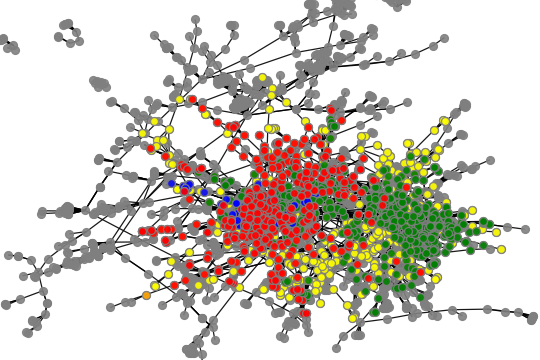

In [35]:
visualize_all_partitions(data, core_zone1,
                         undiscovered_zone1,
                         core_zone2,
                         undiscovered_zone2,
                         intersection_zone)

#### Graph Partitioning labels ###
- Core Zone 1: GREEN
- Undiscovered zone 1: YELLOW
- Core Zone 2: BLUE
- Undiscovered zone 2: ORANGE
- Intersection zone: RED
- Other nodes: GREY

In [10]:
''' Preparing partitions for Neural network '''
train_mask_1 = torch.tensor(bool_mask(core_zone1, data))  # core zone, 1st graph
test_mask_1 = torch.tensor(bool_mask(undiscovered_zone1, data))  # undiscovered zone, 1st graph
train_mask_2 = torch.tensor(bool_mask(core_zone2, data))  # core zone, 2nd graph
test_mask_2 = torch.tensor(bool_mask(undiscovered_zone2, data))  # undiscovered zone, 2nd graph
intersection_mask = torch.tensor(bool_mask(intersection_zone, data))  # intersection zone

### Train Test and Intersection Test utils

In [11]:
def train(nn_model, data, optimizer, criterion, train_mask):
    nn_model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = nn_model(data.x, data.edge_index)  # Perform a single forward pass.
    # Compute the loss solely based on the training nodes.
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss


def test(nn_model, data, test_mask, target_names):
    nn_model.eval()
    out = nn_model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    # Check against ground-truth labels.
    test_correct = pred[test_mask] == data.y[test_mask]
    # Derive ratio of correct predictions.
    test_acc = int(test_correct.sum()) / test_mask.sum()
    report = classification_report(pred[intersection_mask],
        data.y[intersection_mask],
        target_names=target_names,
        zero_division=1)
    return test_acc, report

def test_intersection(nn_model1, nn_model2, data, intersection_mask, target_names):
    "The Intersection zone: tested by both neural networks"
    nn_model1.eval()
    nn_model2.eval()

    out1 = nn_model1(data.x, data.edge_index)
    out2 = nn_model2(data.x, data.edge_index)

    # get the data from the both predictions
    pred = ((out1 + out2)/2).argmax(dim=1)

    # Check against ground-truth labels.
    test_correct = pred[intersection_mask] == data.y[intersection_mask]
    # Derive ratio of correct predictions.
    test_acc = int(test_correct.sum()) / intersection_mask.sum()

    report = classification_report(pred[intersection_mask],
        data.y[intersection_mask],
        target_names=target_names,
        zero_division=1)
    return test_acc, report

def test_intersection_weighted(nn_model1, nn_model2, data, test_mask1, test_mask2, intersection_mask, target_names):
    "The Intersection zone: tested by both neural networks"
    nn_model1.eval()
    nn_model2.eval()

    out1 = nn_model1(data.x, data.edge_index)
    out2 = nn_model2(data.x, data.edge_index)

    # calculate weights with regarding proportion
    core_number_1 = torch.sum(test_mask1).float() # number of nodes in core zone 1
    core_number_2 = torch.sum(test_mask2).float() # number of nodes in core zone 2
    core_number_total = core_number_1 + core_number_2 # total in core number
    weight1 = core_number_1 / core_number_total
    weight2 = core_number_2 / core_number_total
    
    # get the data from the both predictions by calculating the average with regarding the proportion of train data
    pred = ((weight1 * out1 + weight2 * out2)/2).argmax(dim=1)

    # Check against ground-truth labels.
    test_correct = pred[intersection_mask] == data.y[intersection_mask]
    # Derive ratio of correct predictions.
    test_acc = int(test_correct.sum()) / intersection_mask.sum()

    report = classification_report(pred[intersection_mask],
        data.y[intersection_mask],
        target_names=target_names,
        zero_division=1)
    return test_acc, report

print(f"{torch.sum(train_mask_1).float()} {torch.sum(train_mask_2).float()}")

633.0 68.0


## Model1: GraphConv

In [12]:
model1 = GCN(dataset, hidden_channels=16)
model2 = GCN(dataset, hidden_channels=16)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=5e-4)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=5e-4)
criterion1 = torch.nn.CrossEntropyLoss()
criterion2 = torch.nn.CrossEntropyLoss()

In [13]:
loss_list1 = []
loss_list2 = []

for epoch in range(1, 500):
    loss1 = train(model1, data, optimizer1, criterion1, train_mask_1)
    loss2 = train(model2, data, optimizer2, criterion2, train_mask_2)
    loss_list1.append(loss1.item())
    loss_list2.append(loss2.item())
    print(f'Epoch: {epoch:03d}')
    print(f'NN1:{loss1:.4f}, NN2: {loss2:.4f}')

Epoch: 001
NN1:1.7905, NN2: 1.7878
Epoch: 002
NN1:1.7584, NN2: 1.7552
Epoch: 003
NN1:1.7241, NN2: 1.7119
Epoch: 004
NN1:1.6894, NN2: 1.6669
Epoch: 005
NN1:1.6480, NN2: 1.6058
Epoch: 006
NN1:1.6064, NN2: 1.5581
Epoch: 007
NN1:1.5637, NN2: 1.4918
Epoch: 008
NN1:1.5252, NN2: 1.4576
Epoch: 009
NN1:1.4843, NN2: 1.3753
Epoch: 010
NN1:1.4399, NN2: 1.3285
Epoch: 011
NN1:1.3783, NN2: 1.2545
Epoch: 012
NN1:1.3432, NN2: 1.1571
Epoch: 013
NN1:1.2874, NN2: 1.1469
Epoch: 014
NN1:1.2513, NN2: 1.0671
Epoch: 015
NN1:1.2176, NN2: 1.0093
Epoch: 016
NN1:1.1688, NN2: 0.9358
Epoch: 017
NN1:1.1304, NN2: 0.8735
Epoch: 018
NN1:1.1011, NN2: 0.8342
Epoch: 019
NN1:1.0505, NN2: 0.7332
Epoch: 020
NN1:1.0185, NN2: 0.6882
Epoch: 021
NN1:0.9629, NN2: 0.6890
Epoch: 022
NN1:0.9615, NN2: 0.6256
Epoch: 023
NN1:0.9127, NN2: 0.6112
Epoch: 024
NN1:0.8967, NN2: 0.5296
Epoch: 025
NN1:0.8872, NN2: 0.5118
Epoch: 026
NN1:0.8580, NN2: 0.4921
Epoch: 027
NN1:0.8162, NN2: 0.4571
Epoch: 028
NN1:0.8129, NN2: 0.4937
Epoch: 029
NN1:0.787

Epoch: 241
NN1:0.1445, NN2: 0.0779
Epoch: 242
NN1:0.1754, NN2: 0.0234
Epoch: 243
NN1:0.1693, NN2: 0.0352
Epoch: 244
NN1:0.1598, NN2: 0.0286
Epoch: 245
NN1:0.1408, NN2: 0.0128
Epoch: 246
NN1:0.1358, NN2: 0.0305
Epoch: 247
NN1:0.1632, NN2: 0.0213
Epoch: 248
NN1:0.1486, NN2: 0.0227
Epoch: 249
NN1:0.1549, NN2: 0.0197
Epoch: 250
NN1:0.1531, NN2: 0.0478
Epoch: 251
NN1:0.1479, NN2: 0.0407
Epoch: 252
NN1:0.1414, NN2: 0.0245
Epoch: 253
NN1:0.1409, NN2: 0.0326
Epoch: 254
NN1:0.1760, NN2: 0.0162
Epoch: 255
NN1:0.1602, NN2: 0.0357
Epoch: 256
NN1:0.1536, NN2: 0.0296
Epoch: 257
NN1:0.1328, NN2: 0.0084
Epoch: 258
NN1:0.1469, NN2: 0.0410
Epoch: 259
NN1:0.1669, NN2: 0.0242
Epoch: 260
NN1:0.1611, NN2: 0.0435
Epoch: 261
NN1:0.1596, NN2: 0.0344
Epoch: 262
NN1:0.1495, NN2: 0.0197
Epoch: 263
NN1:0.1547, NN2: 0.0443
Epoch: 264
NN1:0.1497, NN2: 0.0189
Epoch: 265
NN1:0.1455, NN2: 0.0303
Epoch: 266
NN1:0.1464, NN2: 0.0404
Epoch: 267
NN1:0.1398, NN2: 0.0136
Epoch: 268
NN1:0.1554, NN2: 0.0229
Epoch: 269
NN1:0.169

Epoch: 476
NN1:0.1423, NN2: 0.0190
Epoch: 477
NN1:0.1229, NN2: 0.0154
Epoch: 478
NN1:0.1234, NN2: 0.0106
Epoch: 479
NN1:0.1283, NN2: 0.0211
Epoch: 480
NN1:0.1214, NN2: 0.0808
Epoch: 481
NN1:0.1196, NN2: 0.0299
Epoch: 482
NN1:0.1325, NN2: 0.0134
Epoch: 483
NN1:0.1306, NN2: 0.0083
Epoch: 484
NN1:0.1354, NN2: 0.0132
Epoch: 485
NN1:0.1268, NN2: 0.0183
Epoch: 486
NN1:0.1273, NN2: 0.0129
Epoch: 487
NN1:0.1275, NN2: 0.0226
Epoch: 488
NN1:0.1193, NN2: 0.0256
Epoch: 489
NN1:0.1158, NN2: 0.0151
Epoch: 490
NN1:0.1326, NN2: 0.0329
Epoch: 491
NN1:0.1230, NN2: 0.0404
Epoch: 492
NN1:0.1293, NN2: 0.0183
Epoch: 493
NN1:0.1424, NN2: 0.0211
Epoch: 494
NN1:0.1270, NN2: 0.0146
Epoch: 495
NN1:0.1226, NN2: 0.0240
Epoch: 496
NN1:0.1316, NN2: 0.0150
Epoch: 497
NN1:0.1254, NN2: 0.0271
Epoch: 498
NN1:0.1143, NN2: 0.0175
Epoch: 499
NN1:0.1236, NN2: 0.0118


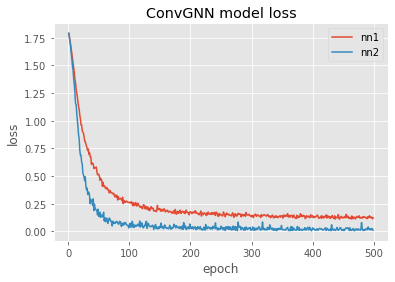

In [14]:
plot_losses(loss_list1, loss_list2, "ConvGNN")

In [15]:
target_names=['c1','c2', 'c3','c4','c5']
test_acc_1, report_1 = test(model1, data, test_mask_1, target_names)
test_acc_2, report_2 = test(model2, data, test_mask_2, target_names)
test_acc_intersection, report_intersection = test_intersection(
    model1, model2, data, intersection_mask, target_names)

test_acc_intersection_weighted, report_intersection_weighted = test_intersection_weighted(model1,
                                                                                          model2,
                                                                                          data,
                                                                                          test_mask_1,
                                                                                          test_mask_2,
                                                                                          intersection_mask,
                                                                                          target_names)

print(f"NN1 Acc:{test_acc_1:.5}, NN2 Acc: {test_acc_2:.5}, ")
print(f"Intersection Acc: {test_acc_intersection:.5}, Intersection weighed: {test_acc_intersection_weighted}")
print('----------------------------------------------------------------------------------')
print('NN1 REPORT')
print(report_1)
print('NN2 REPORT')
print(report_2)
print('NN3 REPORT')
print(report_intersection)

NN1 Acc:0.82042, NN2 Acc: 0.85599, 
Intersection Acc: 0.85, Intersection weighed: 0.8500000238418579
----------------------------------------------------------------------------------
NN1 REPORT
              precision    recall  f1-score   support

          c1       1.00      1.00      1.00         2
          c2       0.55      0.81      0.65        21
          c3       1.00      0.80      0.89         5
          c4       0.99      0.91      0.95       392
          c5       0.00      1.00      0.00         0

    accuracy                           0.90       420
   macro avg       0.71      0.90      0.70       420
weighted avg       0.97      0.90      0.93       420

NN2 REPORT
              precision    recall  f1-score   support

          c1       0.00      1.00      0.00         0
          c2       0.00      1.00      0.00         0
          c3       0.00      1.00      0.00         0
          c4       1.00      0.85      0.92       420
          c5       0.00      1.00 

## Model 2: GraphSage

In [16]:
model1 = GraphSage(dataset, hidden_channels=16)
model2 = GraphSage(dataset, hidden_channels=16)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=5e-4)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=5e-4)
criterion1 = torch.nn.CrossEntropyLoss()
criterion2 = torch.nn.CrossEntropyLoss()

In [17]:
loss_list1 = []
loss_list2 = []

for epoch in range(1, 500):
    loss1 = train(model1, data, optimizer1, criterion1, train_mask_1)
    loss2 = train(model2, data, optimizer2, criterion2, train_mask_2)
    loss_list1.append(loss1.item())
    loss_list2.append(loss2.item())
    print(f'Epoch: {epoch:03d}')
    print(f'NN1:{loss1:.4f}, NN2: {loss2:.4f}')

Epoch: 001
NN1:1.9407, NN2: 1.9329
Epoch: 002
NN1:1.8922, NN2: 1.8762
Epoch: 003
NN1:1.8537, NN2: 1.8262
Epoch: 004
NN1:1.8011, NN2: 1.7772
Epoch: 005
NN1:1.7425, NN2: 1.7212
Epoch: 006
NN1:1.6851, NN2: 1.6090
Epoch: 007
NN1:1.6017, NN2: 1.5371
Epoch: 008
NN1:1.4983, NN2: 1.4461
Epoch: 009
NN1:1.4235, NN2: 1.3584
Epoch: 010
NN1:1.3424, NN2: 1.2608
Epoch: 011
NN1:1.2350, NN2: 1.1458
Epoch: 012
NN1:1.1492, NN2: 1.1427
Epoch: 013
NN1:1.0346, NN2: 0.9144
Epoch: 014
NN1:0.9797, NN2: 0.8926
Epoch: 015
NN1:0.9165, NN2: 0.7424
Epoch: 016
NN1:0.8297, NN2: 0.6757
Epoch: 017
NN1:0.7818, NN2: 0.6139
Epoch: 018
NN1:0.7276, NN2: 0.4937
Epoch: 019
NN1:0.6946, NN2: 0.4563
Epoch: 020
NN1:0.6341, NN2: 0.4544
Epoch: 021
NN1:0.6069, NN2: 0.2805
Epoch: 022
NN1:0.6011, NN2: 0.3167
Epoch: 023
NN1:0.5851, NN2: 0.2459
Epoch: 024
NN1:0.5495, NN2: 0.2312
Epoch: 025
NN1:0.5108, NN2: 0.1736
Epoch: 026
NN1:0.4941, NN2: 0.1855
Epoch: 027
NN1:0.4752, NN2: 0.1754
Epoch: 028
NN1:0.4809, NN2: 0.1453
Epoch: 029
NN1:0.464

Epoch: 237
NN1:0.0665, NN2: 0.0060
Epoch: 238
NN1:0.0636, NN2: 0.0112
Epoch: 239
NN1:0.0669, NN2: 0.0099
Epoch: 240
NN1:0.0665, NN2: 0.0080
Epoch: 241
NN1:0.0661, NN2: 0.0047
Epoch: 242
NN1:0.0799, NN2: 0.0190
Epoch: 243
NN1:0.0666, NN2: 0.0060
Epoch: 244
NN1:0.0763, NN2: 0.0062
Epoch: 245
NN1:0.0589, NN2: 0.0018
Epoch: 246
NN1:0.0524, NN2: 0.0088
Epoch: 247
NN1:0.0736, NN2: 0.0129
Epoch: 248
NN1:0.0499, NN2: 0.0197
Epoch: 249
NN1:0.0673, NN2: 0.0052
Epoch: 250
NN1:0.0645, NN2: 0.0336
Epoch: 251
NN1:0.0729, NN2: 0.0042
Epoch: 252
NN1:0.0640, NN2: 0.0074
Epoch: 253
NN1:0.0925, NN2: 0.0043
Epoch: 254
NN1:0.0699, NN2: 0.0058
Epoch: 255
NN1:0.0746, NN2: 0.0053
Epoch: 256
NN1:0.0733, NN2: 0.0054
Epoch: 257
NN1:0.0669, NN2: 0.0078
Epoch: 258
NN1:0.0664, NN2: 0.0092
Epoch: 259
NN1:0.0550, NN2: 0.0024
Epoch: 260
NN1:0.0683, NN2: 0.0040
Epoch: 261
NN1:0.0696, NN2: 0.0033
Epoch: 262
NN1:0.0773, NN2: 0.0036
Epoch: 263
NN1:0.0682, NN2: 0.0041
Epoch: 264
NN1:0.0745, NN2: 0.0068
Epoch: 265
NN1:0.069

NN1:0.0576, NN2: 0.0044
Epoch: 473
NN1:0.0485, NN2: 0.0013
Epoch: 474
NN1:0.0493, NN2: 0.0057
Epoch: 475
NN1:0.0502, NN2: 0.0073
Epoch: 476
NN1:0.0671, NN2: 0.0064
Epoch: 477
NN1:0.0652, NN2: 0.0070
Epoch: 478
NN1:0.0576, NN2: 0.0071
Epoch: 479
NN1:0.0480, NN2: 0.0037
Epoch: 480
NN1:0.0527, NN2: 0.0027
Epoch: 481
NN1:0.0655, NN2: 0.0026
Epoch: 482
NN1:0.0510, NN2: 0.0022
Epoch: 483
NN1:0.0595, NN2: 0.0014
Epoch: 484
NN1:0.0518, NN2: 0.0037
Epoch: 485
NN1:0.0474, NN2: 0.0025
Epoch: 486
NN1:0.0560, NN2: 0.0051
Epoch: 487
NN1:0.0474, NN2: 0.0015
Epoch: 488
NN1:0.0637, NN2: 0.0090
Epoch: 489
NN1:0.0571, NN2: 0.0117
Epoch: 490
NN1:0.0494, NN2: 0.0023
Epoch: 491
NN1:0.0558, NN2: 0.0013
Epoch: 492
NN1:0.0688, NN2: 0.0021
Epoch: 493
NN1:0.0568, NN2: 0.0193
Epoch: 494
NN1:0.0624, NN2: 0.0056
Epoch: 495
NN1:0.0588, NN2: 0.0049
Epoch: 496
NN1:0.0564, NN2: 0.0041
Epoch: 497
NN1:0.0576, NN2: 0.0024
Epoch: 498
NN1:0.0673, NN2: 0.0022
Epoch: 499
NN1:0.0529, NN2: 0.0077


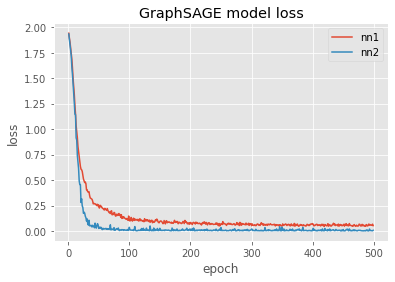

In [18]:
plot_losses(loss_list1, loss_list2, 'GraphSAGE')

In [19]:
target_names=['c1','c2', 'c3','c4','c5']
test_acc_1, report_1 = test(model1, data, test_mask_1, target_names)
test_acc_2, report_2 = test(model2, data, test_mask_2, target_names)
test_acc_intersection, report_intersection = test_intersection(
    model1, model2, data, intersection_mask, target_names)

test_acc_intersection_weighted, report_intersection_weighted = test_intersection_weighted(model1,
                                                                                          model2,
                                                                                          data,
                                                                                          test_mask_1,
                                                                                          test_mask_2,
                                                                                          intersection_mask,
                                                                                          target_names)

print(f"NN1 Acc:{test_acc_1:.5}, NN2 Acc: {test_acc_2:.5}, ")
print(f"Intersection Acc: {test_acc_intersection:.5}, Intersection weighed: {test_acc_intersection_weighted}")
print('----------------------------------------------------------------------------------')
print('NN1 REPORT')
print(report_1)
print('NN2 REPORT')
print(report_2)
print('NN3 REPORT')
print(report_intersection)

NN1 Acc:0.79812, NN2 Acc: 0.85599, 
Intersection Acc: 0.85, Intersection weighed: 0.8571428656578064
----------------------------------------------------------------------------------
NN1 REPORT
              precision    recall  f1-score   support

          c1       1.00      1.00      1.00         2
          c2       0.65      0.77      0.70        26
          c3       1.00      0.80      0.89         5
          c4       0.99      0.91      0.95       387
          c5       0.00      1.00      0.00         0

    accuracy                           0.90       420
   macro avg       0.73      0.90      0.71       420
weighted avg       0.97      0.90      0.93       420

NN2 REPORT
              precision    recall  f1-score   support

          c1       0.00      1.00      0.00         0
          c2       0.00      1.00      0.00         0
          c3       0.00      1.00      0.00         0
          c4       1.00      0.85      0.92       420
          c5       0.00      1.00 

## Model 3 Chebishev net

In [20]:
model1 = ChebyshevNet(dataset, hidden_channels=16, k_parameter=3)
model2 = ChebyshevNet(dataset, hidden_channels=16, k_parameter=3)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=5e-4)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=5e-4)
criterion1 = torch.nn.CrossEntropyLoss()
criterion2 = torch.nn.CrossEntropyLoss()

In [21]:
loss_list1 = []
loss_list2 = []

for epoch in range(1, 500):
    loss1 = train(model1, data, optimizer1, criterion1, train_mask_1)
    loss2 = train(model2, data, optimizer2, criterion2, train_mask_2)
    loss_list1.append(loss1.item())
    loss_list2.append(loss2.item())
    print(f'Epoch: {epoch:03d}')
    print(f'NN1:{loss1:.4f}, NN2: {loss2:.4f}')

Epoch: 001
NN1:1.7857, NN2: 1.7948
Epoch: 002
NN1:1.6899, NN2: 1.6662
Epoch: 003
NN1:1.5808, NN2: 1.5427
Epoch: 004
NN1:1.4758, NN2: 1.3793
Epoch: 005
NN1:1.3603, NN2: 1.2389
Epoch: 006
NN1:1.2418, NN2: 1.0748
Epoch: 007
NN1:1.1593, NN2: 0.9332
Epoch: 008
NN1:1.0479, NN2: 0.7496
Epoch: 009
NN1:0.9200, NN2: 0.5882
Epoch: 010
NN1:0.8481, NN2: 0.5218
Epoch: 011
NN1:0.7550, NN2: 0.4883
Epoch: 012
NN1:0.6928, NN2: 0.3808
Epoch: 013
NN1:0.6222, NN2: 0.3478
Epoch: 014
NN1:0.5931, NN2: 0.2731
Epoch: 015
NN1:0.5438, NN2: 0.2719
Epoch: 016
NN1:0.5152, NN2: 0.2281
Epoch: 017
NN1:0.4788, NN2: 0.2546
Epoch: 018
NN1:0.4397, NN2: 0.1596
Epoch: 019
NN1:0.4172, NN2: 0.1473
Epoch: 020
NN1:0.3915, NN2: 0.1603
Epoch: 021
NN1:0.3967, NN2: 0.1149
Epoch: 022
NN1:0.3583, NN2: 0.0904
Epoch: 023
NN1:0.3396, NN2: 0.0690
Epoch: 024
NN1:0.3487, NN2: 0.0811
Epoch: 025
NN1:0.3211, NN2: 0.0703
Epoch: 026
NN1:0.3009, NN2: 0.0709
Epoch: 027
NN1:0.2718, NN2: 0.0606
Epoch: 028
NN1:0.2661, NN2: 0.0754
Epoch: 029
NN1:0.264

Epoch: 236
NN1:0.0612, NN2: 0.0040
Epoch: 237
NN1:0.0521, NN2: 0.0078
Epoch: 238
NN1:0.0667, NN2: 0.0026
Epoch: 239
NN1:0.0589, NN2: 0.0063
Epoch: 240
NN1:0.0582, NN2: 0.0045
Epoch: 241
NN1:0.0686, NN2: 0.0059
Epoch: 242
NN1:0.0503, NN2: 0.0197
Epoch: 243
NN1:0.0575, NN2: 0.0040
Epoch: 244
NN1:0.0732, NN2: 0.0116
Epoch: 245
NN1:0.0659, NN2: 0.0077
Epoch: 246
NN1:0.0605, NN2: 0.0087
Epoch: 247
NN1:0.0569, NN2: 0.0084
Epoch: 248
NN1:0.0702, NN2: 0.0021
Epoch: 249
NN1:0.0591, NN2: 0.0085
Epoch: 250
NN1:0.0629, NN2: 0.0036
Epoch: 251
NN1:0.0576, NN2: 0.0046
Epoch: 252
NN1:0.0507, NN2: 0.0091
Epoch: 253
NN1:0.0498, NN2: 0.0052
Epoch: 254
NN1:0.0516, NN2: 0.0030
Epoch: 255
NN1:0.0556, NN2: 0.0042
Epoch: 256
NN1:0.0557, NN2: 0.0137
Epoch: 257
NN1:0.0529, NN2: 0.0048
Epoch: 258
NN1:0.0572, NN2: 0.0067
Epoch: 259
NN1:0.0585, NN2: 0.0046
Epoch: 260
NN1:0.0621, NN2: 0.0084
Epoch: 261
NN1:0.0615, NN2: 0.0034
Epoch: 262
NN1:0.0634, NN2: 0.0032
Epoch: 263
NN1:0.0554, NN2: 0.0045
Epoch: 264
NN1:0.060

Epoch: 471
NN1:0.0466, NN2: 0.0038
Epoch: 472
NN1:0.0509, NN2: 0.0034
Epoch: 473
NN1:0.0475, NN2: 0.0050
Epoch: 474
NN1:0.0518, NN2: 0.0057
Epoch: 475
NN1:0.0433, NN2: 0.0029
Epoch: 476
NN1:0.0543, NN2: 0.0061
Epoch: 477
NN1:0.0483, NN2: 0.0043
Epoch: 478
NN1:0.0524, NN2: 0.0058
Epoch: 479
NN1:0.0538, NN2: 0.0077
Epoch: 480
NN1:0.0540, NN2: 0.0033
Epoch: 481
NN1:0.0454, NN2: 0.0060
Epoch: 482
NN1:0.0517, NN2: 0.0029
Epoch: 483
NN1:0.0402, NN2: 0.0028
Epoch: 484
NN1:0.0486, NN2: 0.0031
Epoch: 485
NN1:0.0497, NN2: 0.0070
Epoch: 486
NN1:0.0502, NN2: 0.0045
Epoch: 487
NN1:0.0454, NN2: 0.0042
Epoch: 488
NN1:0.0496, NN2: 0.0037
Epoch: 489
NN1:0.0364, NN2: 0.0028
Epoch: 490
NN1:0.0366, NN2: 0.0009
Epoch: 491
NN1:0.0316, NN2: 0.0033
Epoch: 492
NN1:0.0571, NN2: 0.0034
Epoch: 493
NN1:0.0496, NN2: 0.0026
Epoch: 494
NN1:0.0448, NN2: 0.0029
Epoch: 495
NN1:0.0506, NN2: 0.0070
Epoch: 496
NN1:0.0545, NN2: 0.0059
Epoch: 497
NN1:0.0518, NN2: 0.0036
Epoch: 498
NN1:0.0393, NN2: 0.0020
Epoch: 499
NN1:0.056

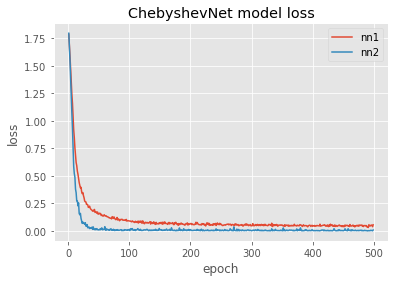

In [22]:
plot_losses(loss_list1, loss_list2, 'ChebyshevNet')

In [23]:
target_names=['c1','c2', 'c3','c4','c5']
test_acc_1, report_1 = test(model1, data, test_mask_1, target_names)
test_acc_2, report_2 = test(model2, data, test_mask_2, target_names)
test_acc_intersection, report_intersection = test_intersection(
    model1, model2, data, intersection_mask, target_names)

test_acc_intersection_weighted, report_intersection_weighted = test_intersection_weighted(model1,
                                                                                          model2,
                                                                                          data,
                                                                                          test_mask_1,
                                                                                          test_mask_2,
                                                                                          intersection_mask,
                                                                                          target_names)

print(f"NN1 Acc:{test_acc_1:.5}, NN2 Acc: {test_acc_2:.5}, ")
print(f"Intersection Acc: {test_acc_intersection:.5}, Intersection weighed: {test_acc_intersection_weighted}")
print('----------------------------------------------------------------------------------')
print('NN1 REPORT')
print(report_1)
print('NN2 REPORT')
print(report_2)
print('NN3 REPORT')
print(report_intersection)

NN1 Acc:0.83333, NN2 Acc: 0.85275, 
Intersection Acc: 0.85238, Intersection weighed: 0.8595238327980042
----------------------------------------------------------------------------------
NN1 REPORT
              precision    recall  f1-score   support

          c1       1.00      1.00      1.00         2
          c2       0.61      0.76      0.68        25
          c3       1.00      0.36      0.53        11
          c4       0.97      0.91      0.94       382
          c5       0.00      1.00      0.00         0

    accuracy                           0.88       420
   macro avg       0.72      0.81      0.63       420
weighted avg       0.95      0.88      0.91       420

NN2 REPORT
              precision    recall  f1-score   support

          c1       0.00      1.00      0.00         0
          c2       0.00      1.00      0.00         0
          c3       0.00      1.00      0.00         0
          c4       1.00      0.85      0.92       420
          c5       0.00      1.